In [1]:
#Simple_sentiment_prediction()
#Build_Dictionary(training_corpus)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# <font color=blue>*Natural language Processing Applications - Example Codes*</font>

# *Chapter-4 $<$Name of Chapter$>$* 
## Welcome to your first text classification task. This notebook will give you a brief overview of text classification and some basic preprocessing of the text data. We will work on Sentiment classification task and the data we use is from Kaggle. 

https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data

In [3]:
#load required libraries
import re
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
color = sns.color_palette()

from nltk.corpus import stopwords
from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Section 2: Load the dataset

In [4]:
#read data from pandas
dataset = pd.read_csv("./datasets/Tweets.csv")

## Section 3 : Explore the Data 

In [5]:
#check first few rows of dataset
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# size of data
dataset.shape 

(14640, 15)

In [7]:
# type of columns in data
dataset.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [8]:
# null values in each column
dataset.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

## Some observations after reading the data :
<br>
* Size of our data is <font color= green>(14640, 15)</font> i.e we have *14640 rows and 15 columns*.
<br>
* Our data consists of both <font color= blue>*numeric and categorical variables* </font>. 
<br>
* We can also see the number of <font color= red>*null values*</font> in each column of our data.

### Let's explore our target variable which is airline_sentiment

In [9]:
dataset["airline_sentiment"].value_counts() / dataset.shape[0]

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

### We can see 62.6 $\%$ rows corresponds to <font color= red>*Negative sentiment*</font> in our data. 
### Lets create a bar plot for our classes.

Text(0.5,0,'Sentiment')

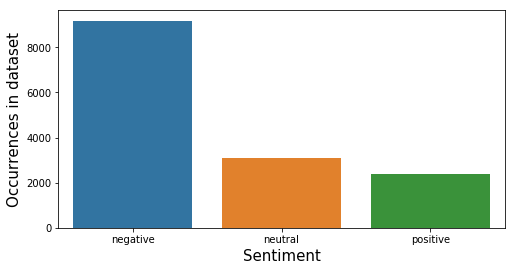

In [10]:
%matplotlib inline
count_sentiment = dataset["airline_sentiment"].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_sentiment.index, count_sentiment.values)
plt.ylabel('Occurrences in dataset', fontsize=15)
plt.xlabel('Sentiment', fontsize=15)

## <font color=blue>*We will focus only on text data so lets create a new dataset which consists of the tweets and correponding sentiment*</font>

In [11]:
text_dataset = dataset[["text", "airline_sentiment"]]

In [12]:
#rename the columns 
text_dataset.columns = ["Tweet", "Sentiment"] 

In [13]:
text_dataset.head()

,Tweet,Sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## Section 4 : *Basic Preprocessing on our Text dataset*  

In this section we will focus on the preprocessing of our data. Preprocessing is one of the most important step in doing data science, in other words we can think of preprocessing as converting the data in the form which any <font color = blue>*Machine Learning*</font> algorithm can digest and give us good results.As you know <font color = red>*'Garbage In Garbage out'*</font> so it is always a good practice to preprocess your data.Since we are focusing on Text data so let's talk about text first.

Text can be any form for ex: it can be a word, a sentence, a paragraph or some sentence with special characters(like tweets) so before feeding it to any model we should first clean our text. 


In [14]:
# Set of stop words in english
stops = set(stopwords.words("english")) 

In [15]:
def clean_tweet(tweet):
    tweet = tweet.lower() # convert tweets to lower case
    tweet = " ".join(filter(lambda x:x[0]!='@', tweet.split())) # remove user ids from the tweet
    tweet = " ".join(filter(lambda x:x[0]!='#', tweet.split())) # remove hash tags from the tweet
    tweet = re.sub("[^a-zA-Z]+", " ", tweet) # keep only alphabets
    tweet = " ".join([w for w in tweet.split() if not w in stops]) # remove stop words
    return tweet

In [16]:
# create new column in dataframe with cleaned tweets
text_dataset["Clean_Tweet"] = text_dataset["Tweet"].apply(clean_tweet)

/home/shreyans/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
text_dataset.head()

,Tweet,Sentiment,Clean_Tweet
0,@VirginAmerica What @dhepburn said.,neutral,said
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing


In [18]:
# function for n_grams
def find_ngrams(text, n):
    return list(itertools.combinations(text, n))

In [19]:
# empty dictionary
D = {}

In [20]:
#function to create dictionary
def create_dict(row):
    value = 0
    if row["Sentiment"] == "positive":
        value = 1
    elif row["Sentiment"] == "negative":
        value = -1
    tweet = row["Clean_Tweet"]
    tweet = tweet.split()
    ngrams = []
    for i in range(1,4):
        ngrams = ngrams + find_ngrams(tweet, i)
    ngrams = [" ".join(i) for i in ngrams]
    for gram in ngrams:
        if gram in D:
            D[gram] += value
        else:
            D[gram] = value

### Section 5: Split our dataset into train and test.

In [21]:
train_data, test_data = train_test_split(text_dataset, test_size = 0.2, random_state = 82,
                                         stratify = text_dataset["Sentiment"])

In [22]:
print (train_data.shape) 

print (test_data.shape)

(11712, 3)
(2928, 3)


### Section 6: Creating a dictionary.

In [23]:
_ = train_data.apply(create_dict, axis = 1)

In [24]:
len(D)

1777160

In [25]:
dict(list(D.items())[0:20])

{'reaching': -4,
 'reaching sooner': 1,
 'sooner': -1,
 'thanks': 237,
 'thanks reaching': -1,
 'thanks sooner': 1,
 'thanks tried': 1,
 'tried': -94,
 'tried reaching': 0,
 'tried sooner': 1,
 'understood': -3,
 'understood reaching': 1,
 'understood sooner': 1,
 'understood thanks': 2,
 'understood thanks reaching': 1,
 'understood thanks sooner': 1,
 'understood thanks tried': 1,
 'understood tried': 1,
 'understood tried reaching': 1,
 'understood tried sooner': 1}

### Section 7: Create Rule Based Classifier 

In [26]:
#Rule based function to predict sentiment
def predict_sentiment(tweet):
    tweet = tweet.split()
    ngrams = []
    for i in range(1,4):
        ngrams = ngrams + find_ngrams(tweet, i)
    ngrams = [" ".join(i) for i in ngrams]
    s = 0
    for gram in ngrams:
        if gram in D:
            value = D[gram]
            if value < 0:
                s -= 1
            elif value > 0:
                s += 1
    if s < 0:
        return "negative"
    elif s > 0:
        return "positive"
    else:
        return "neutral"

### Section 8: Predicting on test data

In [27]:
#predict sentiment on test data
test_data["prediction"] = test_data["Clean_Tweet"].apply(predict_sentiment)

/home/shreyans/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
test_data.head()

,Tweet,Sentiment,Clean_Tweet,prediction
2227,"@united Well, to the degree that he could... J...",negative,well degree could know experience cancelled fl...,negative
2059,@united what's with the layover in Canada from...,neutral,layover canada ua scheduled,negative
3749,@united I will be stunned if my bags are in Ha...,negative,stunned bags hartford ord ground crew hour mov...,negative
8130,@JetBlue U said 15mins to Take Off and now we ...,negative,u said mins take told hr delay amp possible ca...,negative
1779,"@united - well, now finally on board hopefully...",negative,well finally board hopefully take time quickly...,negative


In [29]:
print("Accuracy on test set: {0:.2f}%".format(accuracy_score(test_data["Sentiment"], test_data["prediction"])*100))

Accuracy on test set: 66.67%


### Let's explore the predicted values

In [30]:
test_data["prediction"].value_counts()/test_data.shape[0]

negative    0.92862
positive    0.05123
neutral     0.02015
Name: prediction, dtype: float64

### We can see that for 92.8 $\%$ of rows in test data we have predicted sentiment as <font color= red>*Negative*</font>.

In [31]:
test_data["Sentiment"].value_counts()/test_data.shape[0]

negative    0.627049
neutral     0.211749
positive    0.161202
Name: Sentiment, dtype: float64

### but originally there are 62.7 $\%$ rows in data which corresponds to <font color= red>*Negative Sentiment*</font>.

# Section 9: Confusion matrix 
We use Confusion matrix(cm) to check the correctness of our classification algorithm. You might get a Question over here that We have already calculated the Accuracy of our classifier then why another measure to evaluate model performance? 
<br>
Accuracy is the ratio of <font color = blue>*correctly classified*</font> data points to *total* data points, so it is obvious that better the accuracy better is our classifier. Lets deep dive into this and define some terms: 
<br> 
* True Positives(TP): Number of examples which have actual label as <font color = blue>*Positive*</font> and classifier also predicted as <font color = blue>*Positive*</font>. 
<br> 
* False Positives(FP): Number of examples which have actual label as <font color = red>*Negative*</font> and classifier predicted as <font color = blue>*Positive*</font>. 
<br> 
* True Negatives(TP): Number of examples which have actual label as <font color = red>*Negative*</font> and classifier also predicted as <font color= red>*Negative*</font>. 
<br> 
* False Negatives(FP): Number of examples which have actual label as <font color = blue>*Positive*</font> and classifier predicted as <font color=red>*Negative*</font>.
<br> 
<br>
So with the above terms we can write **Accuracy = $($ TP+TN $)$ $/$ $($ TP+FP+TN+FN $)$** 

### Let's walk through a small example to understand how these terms are helpful to us. Assume we are working on binary classification problem with class labels <font color = blue>*Positive*</font> and <font color =red>*Negative*</font>.  Consider the table below:  
<br>
<table>
<thead>
<tr>
<th></th>
<th>Classified positive</th>
<th>Classified negative</th>
</tr>
</thead>

<tbody>
<tr>
<td>Positive class</td>
<td>10 (TP)</td>
<td>15 (FN)</td>
</tr>

<tr>
<td>Negative class</td>
<td>25 (FP)</td>
<td>100 (TN)</td>
</tr>
</tbody>
</table> 
<br>  
In this case **Accuracy** = $($ 10+100 $)$ $/$ $($ 10+15+25+100 $)$ which comes to **73.3 $\%$**
<br> 
<br>
Now consider a case in which our classifier is only predicting the class label as <font color =red>*Negative*</font> for every data point. so the table will be changed as follows: 
<br> 
<table>
<thead>
<tr>
<th></th>
<th>Classified positive</th>
<th>Classified negative</th>
</tr>
</thead>

<tbody>
<tr>
<td>Positive class</td>
<td>0 (TP)</td>
<td>25 (FN)</td>
</tr>

<tr>
<td>Negative class</td>
<td>0 (FP)</td>
<td>125 (TN)</td>
</tr>
</tbody>
</table> 
<br> 
In this case **Accuracy** = $($ 0+125 $)$ $/$ $($ 0+25+0+125 $)$ which comes to **83.3 $\%$**.  
<br>
<br> 
Even though the classifier in second case is doing nothing but the accuracy of that classifier is high as compared to classifier-1. This is known as **Accuracy Paradox**. As we can see from the table-2 that Number of data points belonging to Negative class is more as compared to Positive class, in other words we can say our data is not balanced with classes so this type of problem is known as **Imbalance Classification Problem**. 
<br> 
<br> 
If we see our dataset also we have around **62 $\%$** data points belongs to <font color=red> **Negative Class** </font> so our dataset is also not balanced so for us also Accuracy is not the correct measure to evaluate our Classifier.

In [32]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

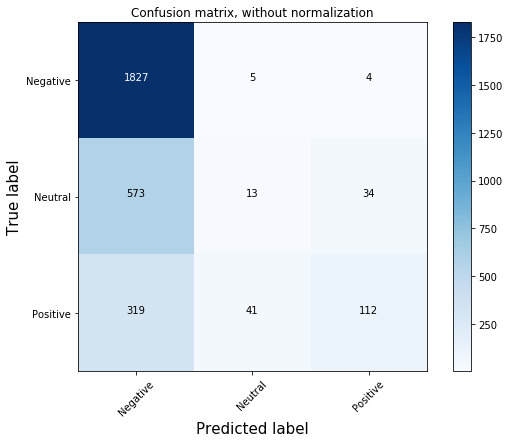

In [33]:
cnf_matrix = confusion_matrix(test_data["Sentiment"], test_data["prediction"])

plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix, without normalization')

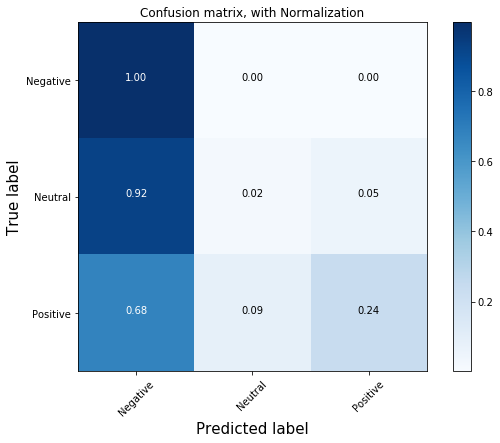

In [34]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix, with Normalization')

## Some observations from <font color = blue>*Confusion Matrix* </font>  :
<br>
* We have correctly predicted the <font color= red>*Negative Class*</font>. 
<br>
* When the true class is <font color= green>*Neutral*</font> we have predicted that class as <font color = red>*Negative*</font> 92 $\%$ of time. 
<br>
* When the true class is <font color= brown>*Positive*</font> we have predicted that class as <font color = red>*Negative*</font> 68 $\%$ of time. 